<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Gridsearching Hyperparameters

_Authors: Kiefer Katovich (SF), David Yerrington (SF)_

---

![](https://snag.gy/aYcCt2.jpg)

### Learning Objective
- Describe what the terms gridsearch and hyperparameter mean.
- Build a gridsearching procedure from scratch.
- Apply sklearn's `GridSearchCV` object with basketball data to optimize a KNN model.
- Use and evaluate attributes of the gridsearch object.
- Describe the pitfalls of searching large hyperparameter spaces.

### Lesson Guide
- [What is "grid searching"? What are "hyperparameters"?](#intro)
- [Basketball Data](#basketball-data)
- [Fitting a Default KNN](#fit-knn)
- [Searching for the Best Hyperparameters](#searching)
    - [Grid Search Pseudocode](#pseudocode)
    - [Using `GridSearchCV`](#gscv)
- [A Caution on Grid Searching](#caution)
- [Independent Practice: Grid Searching Regularization Penalties with Logistic Regression](#practice)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='intro'></a>

## What is "Grid Searching"? What are "Hyperparameters"?

---

Models often have built-in specifications that we can use to fine-tune our results. For example, when we choose a linear regression, we may decide to add a penalty to the loss function such as the Ridge or the Lasso. Those penalties require the regularization strength, alpha, to be set. 

**These specifications are called hyperparameters.**

Hyperparameters are different from the parameters of the model that result from a fit, such as the coefficients. They are set prior to the fit - usually when we instantiate it - and they affect or determine the model's behavior.

There are often more than one kind of hyperparamter to set for a model. For example, in the KNN algorithm, we have a hyperparameter to set the number of neighbors. We also have a hyperparameter to set the weights, eithe uniform or distance. Generally, we want to know the *optimal* hyperparameter settings, the set that results in the best model evaluation. 

**The search for the optimal set of hyperparameters is called gridsearching.**

Gridsearching gets its name from the fact that we are searching over a "grid" of parameters. For example, imagine the `n_neighbors` hyperparameters on the x-axis and `weights` on the y-axis, and we need to test all points on the grid.

**Gridsearching uses cross-validation internally to evaluate the performance of each set of hyperparameters.** More on this later.

<a id='basketball-data'></a>

## Basketball Data

---

To explore the process of gridsearching over sets of hyperparameters, we will use some basketball data. The data below has statistics for 4 different seasons of NBA basketball: 2013-2016.
- This data includes aggregate statistical data for each game. 
- The data of each game is aggregated by match for all players.
- Scraped from http://www.basketball-reference.com

Many of the columns in the dataset represent the mean of a statistic across the last 10 games, for example. Non-target statistics are for *prior* games, they do not include information about player performance in the current game.

**We are interested in predicting whether the home team will win the game or not.** This is a classification problem.


### Load the data and create the target and predictor matrix
- The target will be a binary column of whether the home team wins.
- The predictors should be numeric statistics columns.

Exclude these columns from the predictor matrix:

    ['GameId','GameDate','GameTime','HostName',
     'GuestName','total_score','total_line','game_line',
     'winner','loser','host_wins','Season']


In [3]:
data = pd.read_csv('datasets/basketball_data.csv')

In [4]:
data.columns

Index(['Season', 'GameId', 'GameDate', 'GameTime', 'HostName', 'GuestName',
       'total_score', 'total_line', 'game_line', 'Host_HostRank',
       'Host_GameRank', 'Guest_GuestRank', 'Guest_GameRank', 'host_win_count',
       'host_lose_count', 'guest_win_count', 'guest_lose_count', 'game_behind',
       'winner', 'loser', 'host_place_streak', 'guest_place_streak',
       'hq1_avg10', 'hq2_avg10', 'hq3_avg10', 'hq4_avg10', 'hPace_avg10',
       'heFG%_avg10', 'hTOV%_avg10', 'hORB%_avg10', 'hFT/FGA_avg10',
       'hORtg_avg10', 'hFG_avg10', 'hFGA_avg10', 'hFG%_avg10', 'h3P_avg10',
       'h3PA_avg10', 'h3P%_avg10', 'hFT_avg10', 'hFTA_avg10', 'hFT%_avg10',
       'hORB_avg10', 'hDRB_avg10', 'hTRB_avg10', 'hAST_avg10', 'hSTL_avg10',
       'hBLK_avg10', 'hTOV_avg10', 'hPF_avg10', 'hPTS_avg10', 'hTS%_avg10',
       'h3PAR_avg10', 'hFTr_avg10', 'hDRB%_avg10', 'hTRB%_avg10',
       'hAST%_avg10', 'hSTL%_avg10', 'hBLK%_avg10', 'hDRtg_avg10', 'gq1_avg10',
       'gq2_avg10', 'gq3_avg10', 'gq

In [5]:
# A:

data[['HostName','GuestName', 'winner']].head()

,HostName,GuestName,winner
0,Los Angeles Lakers,Utah Jazz,Utah Jazz
1,Philadelphia 76ers,Detroit Pistons,Philadelphia 76ers
2,Houston Rockets,San Antonio Spurs,San Antonio Spurs
3,Brooklyn Nets,New York Knicks,New York Knicks
4,Detroit Pistons,Denver Nuggets,Denver Nuggets


In [6]:
import numpy as np
data['game_won_by_hosts'] = np.where(data['HostName']==data['winner'],1,0)

In [7]:
data[['HostName','GuestName', 'winner', 'game_won_by_hosts']].head(10)

,HostName,GuestName,winner,game_won_by_hosts
0,Los Angeles Lakers,Utah Jazz,Utah Jazz,0
1,Philadelphia 76ers,Detroit Pistons,Philadelphia 76ers,1
2,Houston Rockets,San Antonio Spurs,San Antonio Spurs,0
3,Brooklyn Nets,New York Knicks,New York Knicks,0
4,Detroit Pistons,Denver Nuggets,Denver Nuggets,0
5,Phoenix Suns,Utah Jazz,Phoenix Suns,1
6,Orlando Magic,Golden State Warriors,Orlando Magic,1
7,Atlanta Hawks,Golden State Warriors,Golden State Warriors,0
8,Miami Heat,Washington Wizards,Miami Heat,1
9,Oklahoma City Thunder,San Antonio Spurs,Oklahoma City Thunder,1


In [8]:
data.Season.unique()

array([2013, 2014, 2015, 2016], dtype=int64)

In [9]:
excl = ['GameId','GameDate','GameTime','HostName',
 'GuestName','total_score','total_line','game_line',
 'winner','loser','host_wins','Season', 'game_won_by_hosts']

In [10]:
predictors = [k for k in data.columns if k not in excl]

In [11]:
X = data[predictors]
y = data.game_won_by_hosts.values

### Create the training and testing data
- Test data should be the 2016 season data, training data will be the previous seasons.
- Make sure to standardize your predictor matrix (easiest to do prior to splitting the data into training and testing)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
ss = StandardScaler()

In [14]:
# A:
X_train = X[data.Season.isin([2013, 2014, 2015])]
X_test = X[data.Season.isin([2016])]
X_test2 = X[data.Season==2016]

In [15]:
y_train = y[data.Season.isin([2013, 2014, 2015])]
y_test = y[data.Season.isin([2016])]

In [16]:
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

<a id='fit-knn'></a>

## Fitting the Default KNN

---

Below we can fit a default `KNeighborsClassifier` to predict win vs. not on the training data, then score it on the testing data. 

Remember to compare your score to the baseline accuracy.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
# A:
knn = KNeighborsClassifier()
knn.fit(X_train_ss, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [19]:
knn.score(X_train_ss, y_train)

0.7495508444125045

In [20]:
knn.score(X_test_ss, y_test)

0.5786802030456852

In [21]:
print(np.mean(y_test))

0.6030456852791878


<a id='searching'></a>

## Searching for the Best Hyperparameters

---

Our default KNN performs quite poorly on the test data. But what if we changed the number of neighbors? The weighting? The distance metric?

These are all hyperparameters of the KNN algorithm. How would we do this manually? We would need to evaluate on the training data the set of hyperparameters that perform best, and then use this set of hyperparameters to fit the final model and score on the testing set.

<a id='pseudocode'></a>
### Gridsearch pseudocode for our KNN

```python
accuracies = {}
for k in neighbors_to_test:
    for w in weightings_to_test:
        for d in distance_metrics_to_test:
            hyperparam_set = (k, w, d)
            knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=d)
            cv_accuracies = cross_val_score(knn, X_train, y_train, cv=5)
            accuracies[hyperparam_set] = np.mean(cv_accuracies)
```

In the pseudocode above, we would find the key in the dictionary (a hyperparameter set) that has the largest value (mean cross-validated accuracy).



<a id='gscv'></a>
### Using `GridSearchCV`

This would be an annoying process to have to do manually. Luckily sklearn comes with a convenience class for performing gridsearch:

```python
from sklearn.model_selection import GridSearchCV
```

The `GridSearchCV` has a handful of important arguments:

| Argument | Description |
| --- | ---|
| **`estimator`** | The sklearn instance of the model to fit on |
| **`param_grid`** | A dictionary where keys are hyperparameters for the model and values are lists of values to test |
| **`cv`** | The number of internal cross-validation folds to run for each set of hyperparameters |
| **`n_jobs`** | How many cores to use on your computer to run the folds (-1 means use all cores) |
| **`verbose`** | How much output to display (0 is none, 1 is limited, 2 is printouts for every internal fit) |


Below is an example for how one might set up the gridsearch for our KNN:

```python
knn_parameters = {
    'n_neighbors':[1,3,5,7,9],
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_gridsearcher.fit(X_train, y_train)
```

**Try out the sklearn gridsearch below on the training data.**

In [48]:
from sklearn.model_selection import GridSearchCV

In [23]:
# A:
knn_parameters = {
    'n_neighbors':[1,3,5,7,9, 15, 21],
    'weights':['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}

In [27]:
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), 
                             knn_parameters,
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

In [28]:
knn_gridsearch = knn_gridsearch.fit(X_train_ss, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   11.5s finished


In [26]:
results = knn_gridsearch.fit(X_train_ss, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-3)]: Done 140 out of 140 | elapsed:   10.9s finished


<a id='gs-results'></a>
### Examining the results of the gridsearch

Once the gridsearch has fit (this can take awhile!) we can pull out a variety of information and useful objects from the gridsearch object, stored as attributes:

| Property | Use |
| --- | ---|
| **`results.param_grid`** | Displays parameters searched over. |
| **`results.best_score_`** | Best mean cross-validated score achieved. |
| **`results.best_estimator_`** | Reference to model with best score.  Is usable / callable. |
| **`results.best_params_`** | The parameters that have been found to perform with the best score. |
| **`results.grid_scores_`** | Display score attributes with corresponding parameters. | 

**Print out the best score found in the search.**

In [29]:
# A:
results.best_score_

0.6115702479338843

**Print out the set of hyperparameters that achieved the best score.**

In [30]:
# A:
results.best_params_

{'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}

In [31]:
results.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_metric', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [32]:
models = pd.DataFrame(results.cv_results_['params'])
models['Mean_test_scores'] = results.cv_results_['mean_test_score']

In [33]:
models.head(10)

,metric,n_neighbors,weights,Mean_test_scores
0,euclidean,1,uniform,0.562343
1,euclidean,1,distance,0.562343
2,euclidean,3,uniform,0.574560
3,euclidean,3,distance,0.574560
4,euclidean,5,uniform,0.589651
5,euclidean,5,distance,0.589651
6,euclidean,7,uniform,0.601150
7,euclidean,7,distance,0.601150
8,euclidean,9,uniform,0.607977
9,euclidean,9,distance,0.607977


metric
euclidean    AxesSubplot(0.08,0.125;0.87x0.755)
manhattan    AxesSubplot(0.08,0.125;0.87x0.755)
Name: Mean_test_scores, dtype: object

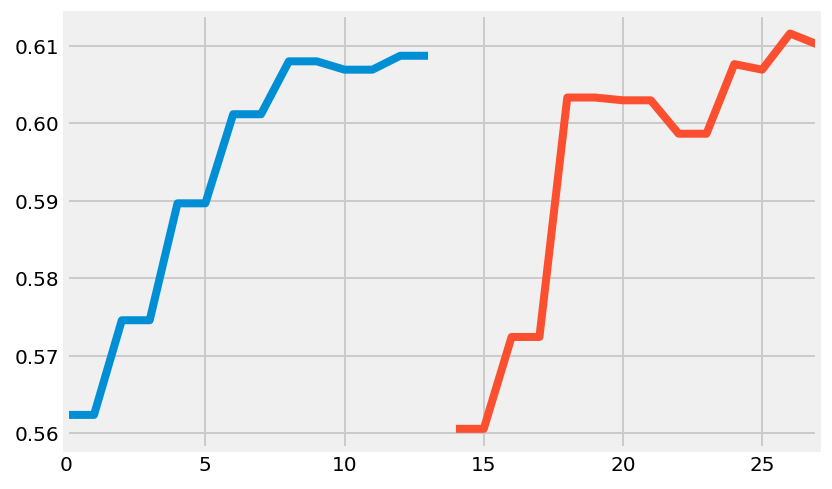

In [34]:
models.groupby('metric')['Mean_test_scores'].plot()

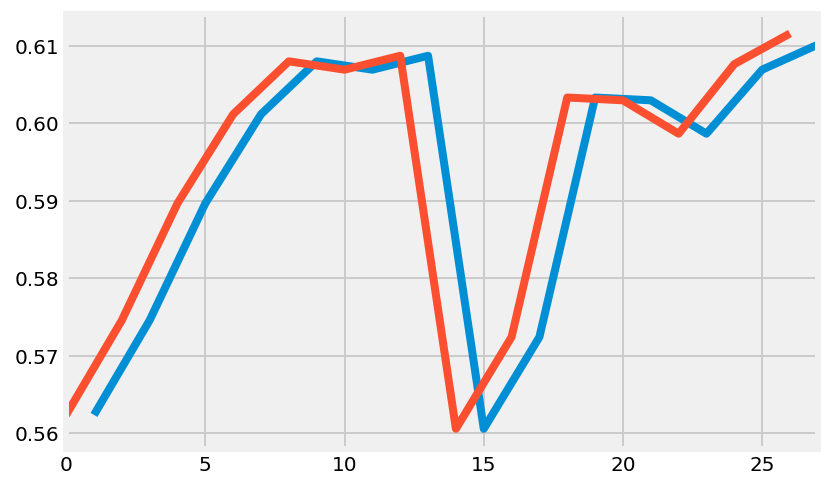

In [49]:
#models[models['n_neighbors']>0]['Mean_test_scores'].plot()
models[models['weights']=='distance']['Mean_test_scores'].plot()
models[models['weights']=='uniform']['Mean_test_scores'].plot()

**Assign the best fit model (`best_estimator_`) to a variable and score it on the test data.**

Compare this model to the baseline accuracy and your default KNN.

In [36]:
# A:
best_fit = results.best_estimator_

In [39]:
best_fit

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [47]:
y_best_fit_hat = best_fit.predict(X_test_ss)

In [46]:
best_fit.score(X_test, y_test)

0.6030456852791878

In [42]:
best_fit.score(X_test_ss, y_test)

0.6345177664974619

In [44]:
round(np.mean(y_test),4)

0.603

In [45]:
knn.score(X_test_ss, y_test)

0.5786802030456852

<a id='caution'></a>

## A Word of Caution on Grid searching

---

Sklearn models often have many options/hyperparameters with many different possible values. It may be tempting to search over a wide variety of them. In general, this is not wise.

Remember that **gridsearch searches over all possible combinations of hyperparamters in the paramter dictionary!**

The KNN model class takes a wider range of options during instantiation than we have explored. Imagine that we had this as our parameter dictionary:

```python
parameter_grid = {
    'n_neighbors':range(1,151),
    'weights':['uniform','distance',custom_function],
    'algorithm':['ball_tree','kd_tree','brute','auto'],
    'leaf_size':range(1,152),
    'metric':['minkowski','euclidean'],
    'p':[1,2]
}
```

**How many different combinations will need to be tested?

| Parameter | Potential Values | Unique Values |
| --- | ---| ---: |
| **n_neighbors** | int range 1-150 | 150 |
| **weights** | strs:  "uniform", "distance" or user defined function | 3 |
| **algorithm** | strs: "ball_tree", "kd_tree", "brute", "auto" | 4 |
| **leaf_size** | int range 1-151 | 151 |
| **metric** | str: "minkowski" or 'euclidean' type | 2 |
| **p** | int: 1=manhattan_distance, 2= euclidean_distance | 2 |
|| <br>_150 \* 3 \* 4 \* 151 \* 2 \* 2 = n combinations_ <br><br>| _1,087,200_ |

Over a million tests *before we even consider the number of cross-validation folds!*

If we're not careful, gridsearching can quickly blow up, taking our time and machine with it. A lot of the hyperparameters we put in the dumb example above are either redundant or not useful.

> **It is extremely important to understand what the hyperparameters do and think critically about what ranges are useful and relevant to your model!**


One way to survey a space of possible parameters without testing every single parameter is to use a randomized search.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

<a id='practice'></a>

## Practice: Grid Search Regularization Penalties with Logistic Regression

---

Logistic regression models can also apply the Lasso and Ridge penalties. The `LogisticRegression` class takes these regularization-relevant hyperparameters:

| Argument | Description |
| --- | ---|
| **`penalty`** | `'l1'` for Lasso, `'l2'` for Ridge |
| **`solver`** | Must be set to `'liblinear'` for the Lasso penalty to work. |
| **`C`** | The regularization strength. Equivalent to `1./alpha` |

**You should:**
1. Fit and validate the accuracy of a default logistic regression on the basketball data.
- Perform a gridsearch over different regularization strengths and Lasso and Ridge penalties.
- Compare the accuracy on the test set of your optimized logistic regression to the baseline accuracy and the default model.
- Look at the best parameters found. What was chosen? What does this suggest about our data?
- Look at the (non-zero, if Lasso was selected as best) coefficients and associated predictors for your optimized model. What appears to be the most important predictors of winning the game?


In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
# A: